# Hello, pytorch

![img](https://s1.postimg.org/6fl45xnvnj/pytorch-logo-dark.png)

__This notebook__ will teach you to use pytorch low-level core. You can install it [here](http://pytorch.org/). For high-level interface see the next notebook.

__Pytorch feels__ differently than tensorflow/theano in almost every level. TensorFlow makes your code live in two "worlds" simultaneously:  symbolic graphs and actual tensors. First you declare a symbolic "recipe" of how to get from inputs to outputs, then feed it with actual minibatches of data.  In pytorch, __there's only one world__: all tensors have a numeric value.

You compute outputs on the fly without pre-declaring anything. The code looks exactly as in pure numpy with one exception: pytorch computes gradients for you. And can run stuff on GPU. And has a number of pre-implemented building blocks for your neural nets. [And a few more things.](https://medium.com/towards-data-science/pytorch-vs-tensorflow-spotting-the-difference-25c75777377b)

And now we finally shut up and let pytorch do the talking.

In [1]:
from __future__ import print_function
import numpy as np
import torch
print(torch.__version__)

0.3.0b0+af3964a


In [2]:
# numpy world

x = np.arange(16).reshape(4,4)

print("X :\n%s\n" % x)
print("X.shape : %s\n" % (x.shape,))
print("add 5 :\n%s\n" % (x + 5))
print("X*X^T  :\n%s\n" % np.dot(x,x.T))
print("mean over cols :\n%s\n" % (x.mean(axis=-1)))
print("cumsum of cols :\n%s\n" % (np.cumsum(x,axis=0)))

X :
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]

X.shape : (4, 4)

add 5 :
[[ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]
 [17 18 19 20]]

X*X^T  :
[[ 14  38  62  86]
 [ 38 126 214 302]
 [ 62 214 366 518]
 [ 86 302 518 734]]

mean over cols :
[ 1.5  5.5  9.5 13.5]

cumsum of cols :
[[ 0  1  2  3]
 [ 4  6  8 10]
 [12 15 18 21]
 [24 28 32 36]]



In [3]:
# pytorch world

x = np.arange(16).reshape(4,4)

x = torch.from_numpy(x).type(torch.FloatTensor) #or torch.arange(0,16).view(4,4)

print ("X :\n%s" % x)
print("X.shape : %s\n" % (x.shape,))
print ("add 5 :\n%s" % (x+5))
print ("X*X^T  :\n%s" % torch.matmul(x,x.transpose(1,0)))
print ("mean over cols :\n%s" % torch.mean(x,dim=-1))
print ("cumsum of cols :\n%s" % torch.cumsum(x,dim=0))

X :

  0   1   2   3
  4   5   6   7
  8   9  10  11
 12  13  14  15
[torch.FloatTensor of size 4x4]

X.shape : torch.Size([4, 4])

add 5 :

  5   6   7   8
  9  10  11  12
 13  14  15  16
 17  18  19  20
[torch.FloatTensor of size 4x4]

X*X^T  :

  14   38   62   86
  38  126  214  302
  62  214  366  518
  86  302  518  734
[torch.FloatTensor of size 4x4]

mean over cols :

  1.5000
  5.5000
  9.5000
 13.5000
[torch.FloatTensor of size 4]

cumsum of cols :

  0   1   2   3
  4   6   8  10
 12  15  18  21
 24  28  32  36
[torch.FloatTensor of size 4x4]



## NumPy and Pytorch

As you can notice, pytorch allows you to hack stuff much the same way you did with numpy. No graph declaration, no placeholders, no sessions. This means that you can _see the numeric value of any tensor at any moment of time_. Debugging such code can be done with by printing tensors or using any debug tool you want (e.g. [gdb](https://wiki.python.org/moin/DebuggingWithGdb)).

You could also notice the a few new method names and a different API. So no, there's no compatibility with numpy [yet](https://github.com/pytorch/pytorch/issues/2228) and yes, you'll have to memorize all the names again. Get excited!

![img](http://i0.kym-cdn.com/entries/icons/original/000/017/886/download.jpg)

For example, 
* If something takes a list/tuple of axes in numpy, you can expect it to take *args in pytorch
 * `x.reshape([1,2,8]) -> x.view(1,2,8)`
* You should swap _axis_ for _dim_ in operations like mean or cumsum
 * `x.sum(axis=-1) -> x.sum(dim=-1)`
* most mathematical operations are the same, but types an shaping is different
 * `x.astype('int64') -> x.type(torch.LongTensor)`

To help you acclimatize, there's a [table](https://github.com/torch/torch7/wiki/Torch-for-Numpy-users) covering most new things. There's also a neat [documentation page](http://pytorch.org/docs/master/).

Finally, if you're stuck with a technical problem, we recommend searching [pytorch forumns](https://discuss.pytorch.org/). Or just googling, which usually works just as efficiently. 

If you feel like you almost give up, remember two things: __GPU__ an __free gradients__. Besides you can always jump back to numpy with x.numpy()

### Warmup: trigonometric knotwork
_inspired by [this post](https://www.quora.com/What-are-the-most-interesting-equation-plots)_

There are some simple mathematical functions with cool plots. For one, consider this:

$$ x(t) = t - 1.5 * cos( 15 t) $$
$$ y(t) = t - 1.5 * sin( 16 t) $$


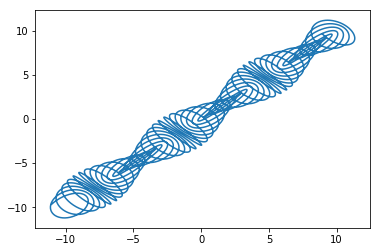

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

t = torch.linspace(-10, 10, steps = 10000)

# compute x(t) and y(t) as defined above
x = t - 1.5 * torch.cos(15 * t)
y = t - 1.5 * torch.sin(16 * t)

plt.plot(x.numpy(), y.numpy())

if you're done early, try adjusting the formula and seing how  it affects the function

## Automatic gradients

Any self-respecting DL framework must do your backprop for you. Torch handles this with __`Variable`__s and the `autograd` module.

The general pipeline looks like this:
* You create ```a = Variable(data, requires_grad=True)```
* You define some differentiable `loss = whatever(a)`
* Call `loss.backward()`
* Gradients are now available as ```a.grads```

__Here's an example:__ let's fit a linear regression on Boston house prices

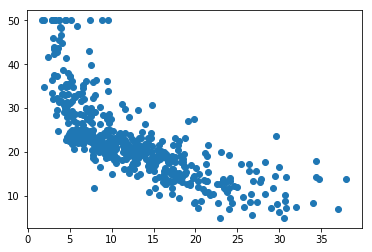

In [5]:
from sklearn.datasets import load_boston
boston = load_boston()
plt.scatter(boston.data[:, -1], boston.target)

In [6]:
from torch.autograd import Variable
w = Variable(0.01 + torch.randn(10)*0.001, requires_grad=True)

# cast data into torch variables
x = Variable(torch.FloatTensor(boston.data[:,-1] / 10))
y = Variable(torch.FloatTensor(boston.target))

In [ ]:
y_pred = w * x + b
loss = torch.mean( (y_pred - y)**2 )

# propagete gradients
loss.backward()

The gradients are now stored in `.grad` of a variable.

In [ ]:
print("dL/dw = \n", w.grad)
print("dL/db = \n", b.grad)

If you compute gradient from multiple losses, the gradients will add up at variables, therefore it's useful to __zero the gradients__ between iteratons.

In [8]:
from IPython.display import clear_output

relu = torch.nn.functional.relu

for i in range(1000):

    y_pred = w[2] * torch.tanh(-1 * w[0] * x + w[1])\
           + w[6]
    loss = torch.mean( (y_pred - y)**2 )
    loss.backward()

    w.data -= 0.05 * w.grad.data
    
    #zero gradients
    w.grad.data.zero_()
    
    # the rest of code is just bells and whistles
    if (i+1)%5==0:
        clear_output(True)
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.scatter(x.data.numpy(), y_pred.data.numpy(), color='orange', linewidth=5)
        plt.show()

        print("loss = ", loss.data.numpy()[0])
        if loss.data.numpy()[0] < 0.5:
            print("Done!")
            break

KeyboardInterrupt: 

__Bonus quest__: try implementing and writing some nonlinear regression. You can try quadratic features or some trigonometry, or a simple neural network. The only difference is that now you have more variables and a more complicated `y_pred`. 

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```


### Tensor vs Variable

![img](https://s1.postimg.org/1i8tinij33/torch_tensor_variable.png)

`    `

Tensor and Variable Weasley were identical and mischievous twin abstractions living in pytorch. Brilliant pranksters, they make sure your code never runs successfully from the first attempt.

Seriously though, Variable wraps around the torch tensor and allows you to compute gradients. Theoretically, Variable acts just like tensor for all intents and purposes. Practically, you will find yourself debugging tensor vs variable issues most of your first 

Ideally, you could wrap everything into Variable from the get-go an forget about Tensor. Hopefully you will once be able to do so __[upvote [this](https://github.com/pytorch/pytorch/issues/2228)]__. 

Right now you can't, but it's getting better with each update.

The good news is that you can always swap between the two seamlessly:
* tensor to variable: `Variable(x)`
* variable to tensor: `x.data`

In [19]:
boston.data

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
        4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
        9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
        4.0300e+00],
       ...,
       [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        5.6400e+00],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
        6.4800e+00],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        7.8800e+00]])

In [9]:
from torch.autograd import Variable

x = torch.arange(0,16).view(4,4).type(torch.IntTensor)
x_var = Variable(x)

print ("Result (tensors):\n", (x == 1) | (x % 3 == 0))
print ("Result (variables):\n", (x_var == 1) | (x_var % 3==0))

Result (tensors):
 
 1  1  0  1
 0  0  1  0
 0  1  0  0
 1  0  0  1
[torch.ByteTensor of size 4x4]

Result (variables):
 Variable containing:
 1  1  0  1
 0  0  1  0
 0  1  0  0
 1  0  0  1
[torch.ByteTensor of size 4x4]



In [10]:
sequence = torch.randn(1,8,10)
filters = torch.randn(2,8,3)

#will work:
print("conv1d (variables):\n",torch.nn.functional.conv1d(Variable(sequence),Variable(filters)))

#will not work:
try:
    print("conv1d (tensors):")
    print(torch.nn.functional.conv1d(sequence,filters))
except Exception as e:
    print (e)



conv1d (variables):
 Variable containing:
(0 ,.,.) = 
   3.3173   2.1427   3.4272  -5.3658 -11.4266  -7.2568   5.0543   7.3646
  -2.8945  13.7563  -1.6173 -16.5161  -6.2690   0.7424   5.4136   4.6002
[torch.FloatTensor of size 1x2x8]

conv1d (tensors):
argument 0 is not a Variable


# High-level pytorch

So far we've been dealing with low-level torch API. While it's absolutely vital for any custom losses or layers, building large neura nets in it is a bit clumsy.

Luckily, there's also a high-level torch interface with a pre-defined layers, activations and training algorithms. 

We'll cover them as we go through a simple image recognition problem: classifying letters into __"A"__ vs __"B"__.


In [42]:
from notmnist import load_notmnist
X_train, y_train, X_test, y_test = load_notmnist(letters='AB')
X_train, X_test = X_train.reshape([-1, 784]), X_test.reshape([-1, 784])

print("Train size = %i, test_size = %i"%(len(X_train),len(X_test)))

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
Done
Train size = 2808, test_size = 937


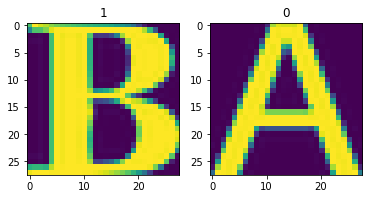

In [45]:
for i in [0,1]:
    plt.subplot(1,2,i+1)
    plt.imshow(X_train[i].reshape([28,28]))
    plt.title(str(y_train[i]))

Let's start with layers. The main abstraction here is __`torch.nn.Module`__

In [46]:
from torch import nn
import torch.nn.functional as F

print(nn.Module.__doc__)

Base class for all neural network modules.

    Your models should also subclass this class.

    Modules can also contain other Modules, allowing to nest them in
    a tree structure. You can assign the submodules as regular attributes::

        import torch.nn as nn
        import torch.nn.functional as F

        class Model(nn.Module):
            def __init__(self):
                super(Model, self).__init__()
                self.conv1 = nn.Conv2d(1, 20, 5)
                self.conv2 = nn.Conv2d(20, 20, 5)

            def forward(self, x):
               x = F.relu(self.conv1(x))
               return F.relu(self.conv2(x))

    Submodules assigned in this way will be registered, and will have their
    parameters converted too when you call .cuda(), etc.
    


There's a vast library of popular layers and architectures already built for ya'.

This is a binary classification problem, so we'll train a __Logistic Regression with sigmoid__.
$$P(y_i | X_i) = \sigma(W \cdot X_i + b) ={ 1 \over {1+e^{- [W \cdot X_i + b]}} }$$


In [47]:
# create a network that stacks layers on top of each other
model = nn.Sequential()

# add first "dense" layer with 784 input units and 1 output unit. 
model.add_module('l1', nn.Linear(784, 1))

# add softmax activation for probabilities. Normalize over axis 1
# note: layer names must be unique
model.add_module('l2', nn.Sigmoid())

In [48]:
print("Weight shapes:", [w.shape for w in model.parameters()])

Weight shapes: [torch.Size([1, 784]), torch.Size([1])]


In [49]:
# create dummy data with 3 samples and 784 features
x = Variable(torch.FloatTensor(X_train[:3]))
y = Variable(torch.FloatTensor(y_train[:3]))

# compute outputs given inputs, both are variables
y_predicted = model(x)[:, 0]

y_predicted # display what we've got

Variable containing:
 0.5295
 0.7300
 0.2932
[torch.FloatTensor of size 3]

Let's now define a loss function for our model.

The natural choice is to use binary crossentropy (aka logloss, negative llh):
$$ L = {1 \over N} \underset{X_i,y_i} \sum - [  y_i \cdot log P(y_i | X_i) + (1-y_i) \cdot log (1-P(y_i | X_i)) ]$$



In [50]:
crossentropy = -y * torch.log(y_predicted) + (y - 1) * torch.log(1 - y_predicted)

loss = torch.mean(crossentropy)

assert tuple(crossentropy.size()) == (3,), "Crossentropy must be a vector with element per sample"
assert tuple(loss.size()) == (1,), "Loss must be scalar. Did you forget the mean/sum?"
assert loss.data.numpy()[0] > 0, "Crossentropy must non-negative, zero only for perfect prediction"
assert loss.data.numpy()[0] <= np.log(3), "Loss is too large even for untrained model. Please double-check it."

When we trained Linear Regression above, we had to manually .zero_() gradients on both our variables. Imagine that code for a 50-layer network.

Again, to keep it from getting dirty, there's `torch.optim` module with pre-implemented algorithms:

In [51]:
opt = torch.optim.RMSprop(model.parameters(), lr=0.01)

# here's how it's used:
loss.backward()      # add new gradients
opt.step()           # change weights
opt.zero_grad()      # clear gradients

In [52]:
# dispose of old variables to avoid bugs later
del x, y, y_predicted, loss, y_pred

NameError: name 'y_pred' is not defined

### Putting it all together

In [61]:
# create network again just in case
model = nn.Sequential()
model.add_module('l1', nn.Linear(784, 50))
model.add_module('l1_relu', nn.ReLU())
model.add_module('l2', nn.Linear(50, 1))
model.add_module('second', nn.Sigmoid())

opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [62]:
history = []

for i in range(100):
    
    # sample 256 random images
    ix = np.random.randint(0, len(X_train), 256)
    x_batch = Variable(torch.FloatTensor(X_train[ix]))
    y_batch = Variable(torch.FloatTensor(y_train[ix]))
    
    # predict probabilities
    y_predicted = model(x_batch)[:,0]
    
    # compute loss, just like before
    loss = torch.mean(-y_batch * torch.log(y_predicted) + (y_batch - 1) * torch.log(1 - y_predicted))
    
    # compute gradients
    loss.backward()
    
    # RMSprop step
    opt.step()
    
    # clear gradients
    opt.zero_grad()
    
    history.append(loss.data.numpy()[0])
    
    if i % 10 == 0:
        print("step #%i | mean loss = %.3f" % (i, np.mean(history[-10:])))

step #0 | mean loss = 0.715
step #10 | mean loss = 0.286
step #20 | mean loss = 0.139
step #30 | mean loss = 0.106
step #40 | mean loss = 0.089
step #50 | mean loss = 0.085
step #60 | mean loss = 0.071
step #70 | mean loss = 0.061
step #80 | mean loss = 0.048
step #90 | mean loss = 0.053


__Debugging tips:__
* make sure your model predicts probabilities correctly. Just print them and see what's inside.
* don't forget _minus_ sign in the loss function! It's a mistake 99% ppl do at some point.
* make sure you zero-out gradients after each step. Srsly:)
* In general, pytorch's error messages are quite helpful, read 'em before you google 'em.
* if you see nan/inf, print what happens at each iteration to find our where exactly it occurs.
  * If loss goes down and then turns nan midway through, try smaller learning rate. (Our current loss formula is unstable).


### Evaluation

Let's see how our model performs on test data

In [63]:
# use your model to predict classes (0 or 1) for all test samples
predicted_y_test = model(Variable(torch.FloatTensor(X_test)))[:,0].data.numpy()
predicted_y_test[predicted_y_test < 0.5] = 0
predicted_y_test[predicted_y_test >= 0.5] = 1
         
assert isinstance(predicted_y_test, np.ndarray), "please return np array, not %s" % type(predicted_y_test)
assert predicted_y_test.shape == y_test.shape, "please predict one class for each test sample"
assert np.in1d(predicted_y_test, y_test).all(), "please predict class indexes"

accuracy = np.mean(predicted_y_test == y_test)

print("Test accuracy: %.5f" % accuracy)
assert accuracy > 0.95, "try training longer"

Test accuracy: 0.97332


## More about pytorch:
* Using torch on GPU and multi-GPU - [link](http://pytorch.org/docs/master/notes/cuda.html)
* More tutorials on pytorch - [link](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
* Pytorch examples - a repo that implements many cool DL models in pytorch - [link](https://github.com/pytorch/examples)
* Practical pytorch - a repo that implements some... other cool DL models... yes, in pytorch - [link](https://github.com/spro/practical-pytorch)
* And some more - [link](https://www.reddit.com/r/pytorch/comments/6z0yeo/pytorch_and_pytorch_tricks_for_kaggle/)

```

```

```

```

```

```

```

```

```

```

# Homework tasks

There will be three tasks worth 2, 3 and 5 points respectively. 
If you get stuck with no progress, try switching to the next task and returning later.

### Task I (2 points) - tensormancy

![img](https://media.giphy.com/media/3o751UMCYtSrRAFRFC/giphy.gif)

When dealing with more complex stuff like neural network, it's best if you use tensors the way samurai uses his sword. 


__1.1 the cannabola__ 
[_disclaimer_](https://gist.githubusercontent.com/justheuristic/e2c1fa28ca02670cabc42cacf3902796/raw/fd3d935cef63a01b85ed2790b5c11c370245cbd7/stddisclaimer.h)

Let's write another function, this time in polar coordinates:
$$\rho(\theta) = (1 + 0.9 \cdot cos (8 \cdot \theta) ) \cdot (1 + 0.1 \cdot cos(24 \cdot \theta)) \cdot (0.9 + 0.05 \cdot cos(200 \cdot \theta)) \cdot (1 + sin(\theta))$$


Then convert it into cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)) and plot the results.

Use torch tensors only: no lists, loops, numpy arrays, etc.

In [ ]:
theta = torch.linspace(- np.pi, np.pi, steps=1000)

# compute rho(theta) as per formula above
rho = ### YOUR CODE

# Now convert polar (rho, theta) pairs into cartesian (x,y) to plot them.
x = ### YOUR CODE
y = ### YOUR CODE


plt.figure(figsize=[6,6])
plt.fill(x.numpy(), y.numpy(), color='green')
plt.grid()

### Task II: the game of life (3 points)

Now it's time for you to make something more challenging. We'll implement Conway's [Game of Life](http://web.stanford.edu/~cdebs/GameOfLife/) in _pure pytorch_. 

While this is still a toy task, implementing game of life this way has one cool benefit: __you'll be able to run it on GPU! __ Indeed, what could be a better use of your gpu than simulating game of life on 1M/1M grids?

![img](https://cdn.tutsplus.com/gamedev/authors/legacy/Stephane%20Beniak/2012/09/11/Preview_Image.png)
If you've skipped the url above out of sloth, here's the game of life:
* You have a 2D grid of cells, where each cell is "alive"(1) or "dead"(0)
* Any living cell that has 2 or 3 neighbors survives, else it dies [0,1 or 4+ neighbors]
* Any cell with exactly 3 neighbors becomes alive (if it was dead)

For this task, you are given a reference numpy implementation that you must convert to pytorch.
_[numpy code inspired by: https://github.com/rougier/numpy-100]_


__Note:__ You can find convolution in `torch.nn.functional.conv2d(Z,filters)`. Note that it has a different input format. 


In [ ]:
from scipy.signal import convolve2d

def np_update(Z):
    # Count neighbours with convolution
    filters = np.array([[1,1,1],
                        [1,0,1],
                        [1,1,1]])
    
    N = convolve2d(Z,filters,mode='same')
    
    # Apply rules
    birth = (N==3) & (Z==0)
    survive = ((N==2) | (N==3)) & (Z==1)
    
    Z[:] = birth | survive
    return Z

In [ ]:
def torch_update(Z):
    """
    Implement an update function that does to Z exactly the same as np_update.
    :param Z: torch.FloatTensor of shape [height,width] containing 0s(dead) an 1s(alive)
    :returns: torch.FloatTensor Z after updates.
    
    You can opt to create new tensor or change Z inplace.
    """
    
    #<Your code here!>
    
    return Z


In [ ]:
#initial frame
Z_numpy = np.random.choice([0,1],p=(0.5,0.5),size=(100,100))
Z = torch.from_numpy(Z_numpy).type(torch.FloatTensor)

#your debug polygon :)
Z_new = torch_update(Z.clone())

#tests
Z_reference = np_update(Z_numpy.copy())
assert np.all(Z_new.numpy() == Z_reference), "your pytorch implementation doesn't match np_update. Look into Z and np_update(ZZ) to investigate."
print("Well done!")

In [ ]:
%matplotlib notebook
plt.ion()

#initialize game field
Z = np.random.choice([0,1],size=(100,100))
Z = torch.from_numpy(Z).type(torch.FloatTensor)

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for _ in range(100):
    
    #update
    Z = torch_update(Z)
    
    #re-draw image
    ax.clear()
    ax.imshow(Z.numpy(),cmap='gray')
    fig.canvas.draw()


In [ ]:
#Some fun setups for your amusement

#parallel stripes
Z = np.arange(100)%2 + np.zeros([100,100])
#with a small imperfection
Z[48:52,50]=1

Z = torch.from_numpy(Z).type(torch.FloatTensor)

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for _ in range(100):
    Z = torch_update(Z)
    ax.clear()
    ax.imshow(Z.numpy(),cmap='gray')
    fig.canvas.draw()

More fun with Game of Life: [video](https://www.youtube.com/watch?v=C2vgICfQawE)

```

```

```

```

```

```

```

```

```

```



### Task III: Going deeper (5 points)
<img src="http://download.gamezone.com/uploads/image/data/1190338/article_post_width_a88.jpg" width=360>
Your ultimate task for this week is to build your first neural network [almost] from scratch and pure torch.

This time you will solve the same digit recognition problem, but at a greater scale
* 10 different letters
* 20k samples

We want you to build a network that reaches at least 80% accuracy and has at least 2 linear layers in it. Naturally, it should be nonlinear to beat logistic regression. You can implement it with either 


With 10 classes you will need to use __Softmax__ at the top instead of sigmoid and train for __categorical crossentropy__  (see [here](https://www.kaggle.com/wiki/LogLoss)).  Write your own loss or use `torch.nn.functional.nll_loss`. Just make sure you understand what it accepts as an input.

Note that you are not required to build 152-layer monsters here. A 2-layer (one hidden, one output) neural network should already give you an edge over logistic regression.


__[bonus kudos]__
If you've already beaten logistic regression with a two-layer net, but enthusiasm still ain't gone, you can try improving the test accuracy even further! It should be possible to reach 90% without convnets.

__SPOILERS!__
At the end of the notebook you will find a few tips and frequent errors. 
If you feel confident enogh, just start coding right away and get there ~~if~~ once you need to untangle yourself. 



In [ ]:
from notmnist import load_notmnist
X_train, y_train, X_test, y_test = load_notmnist(letters='ABCDEFGHIJ')
X_train, X_test = X_train.reshape([-1, 784]), X_test.reshape([-1, 784])

In [ ]:
%matplotlib inline
plt.figure(figsize=[12,4])
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.imshow(X_train[i].reshape([28,28]))
    plt.title(str(y_train[i]))

In [ ]:
#< a whole lot of your code > 

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```

```


# SPOILERS!

Recommended pipeline

* Adapt logistic regression from previous assignment to classify one letter against others (e.g. A vs the rest)
* Generalize it to multiclass logistic regression.
  - Either try to remember lecture 0 or google it.
  - Instead of weight vector you'll have to use matrix (feature_id x class_id)
  - softmax (exp over sum of exps) can implemented manually or as nn.Softmax (layer) F.softmax (function)
  - probably better to use STOCHASTIC gradient descent (minibatch) for greater speed
    - you can also try momentum/rmsprop/adawhatever
    - in which case sample should probably be shuffled (or use random subsamples on each iteration)
* Add a hidden layer. Now your logistic regression uses hidden neurons instead of inputs.
  - Hidden layer uses the same math as output layer (ex-logistic regression), but uses some nonlinearity (e.g. sigmoid) instead of softmax
  - You need to train both layers, not just output layer :)
  - __Do not initialize weights with zeros__ (due to symmetry effects). A gaussian noize with small variance will do.
  - 50 hidden neurons and a sigmoid nonlinearity will do for a start. Many ways to improve. 
  - In ideal casae this totals to 2 .dot's, 1 softmax and 1 sigmoid
  - __make sure this neural network works better than logistic regression__
  
* Now's the time to try improving the network. Consider layers (size, neuron count),  nonlinearities, optimization methods, initialization - whatever you want, but please avoid convolutions for now.
  
* If anything seems wrong, try going through one step of training and printing everything you compute.
* If you see NaNs midway through optimization, you can estimate log P(y|x) as via F.log_softmax(layer_before_softmax)

